In [1]:
# !pip3 install tensorflow

In [2]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
from matplotlib import pyplot as plt

## Initialise data

In [3]:
# setup general info on batch sizes and img sizes
batch_size = 32
img_height = 256
img_width = 256

In [4]:
# taken from tf tutorial, unknown what this does so far
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
datadir = os.path.join('..', 'Data', 'segmented_cars')

In [6]:
# generate training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    datadir,
    validation_split= 0.2, # let the program know what the validation split will be in order to choose the correct size of this training set as well
    subset="training", # here we denote that this set will be the *training* set.
    seed=123,
    image_size = (img_height, img_width), # rescale images automatically
    batch_size= batch_size
) 

# randomly shuffle your data.
train_ds_pref = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# automatic labelling with this object, based on dict names.
class_names = train_ds.class_names

Found 3563 files belonging to 5 classes.
Using 2851 files for training.


In [7]:
# generate validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    datadir,
    validation_split= 0.2,
    subset="validation", # here we denote that this set will be the *validation* set.
    seed=123, 
    image_size = (img_height, img_width),
    batch_size= batch_size
)

# function of this line is currently unknown.
val_ds_pref = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3563 files belonging to 5 classes.
Using 712 files for validation.


## Data augmentation

In [8]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Train the model

In [10]:
from tensorflow.keras.layers import Dropout

In [11]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation, # data augmentation as a very first step
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # here we perform the dropout.
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [12]:
# compile the model
model.compile(optimizer='adam', # choose the optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function is same as error function
              metrics=['accuracy']) # choose which metrics to keep track of during optimization

In [13]:
epochs = 30
history = model.fit(
  train_ds_pref,
  validation_data=val_ds_pref,
  epochs=epochs
)

Epoch 1/30
90/90 [==============================] - 64s 650ms/step - loss: 1.6254 - accuracy: 0.2711 - val_loss: 1.5865 - val_accuracy: 0.2781
Epoch 2/30
90/90 [==============================] - 58s 647ms/step - loss: 1.5817 - accuracy: 0.2813 - val_loss: 1.5818 - val_accuracy: 0.2683
Epoch 3/30
90/90 [==============================] - 57s 633ms/step - loss: 1.5790 - accuracy: 0.2732 - val_loss: 1.5698 - val_accuracy: 0.2851
Epoch 4/30
90/90 [==============================] - 56s 625ms/step - loss: 1.5612 - accuracy: 0.2922 - val_loss: 1.6082 - val_accuracy: 0.2514
Epoch 5/30
90/90 [==============================] - 57s 633ms/step - loss: 1.5435 - accuracy: 0.3080 - val_loss: 1.5841 - val_accuracy: 0.2767
Epoch 6/30
90/90 [==============================] - 56s 623ms/step - loss: 1.5234 - accuracy: 0.3273 - val_loss: 1.5657 - val_accuracy: 0.3020
Epoch 7/30
90/90 [==============================] - 56s 624ms/step - loss: 1.5086 - accuracy: 0.3392 - val_loss: 1.6797 - val_accuracy: 0.2823

In [14]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

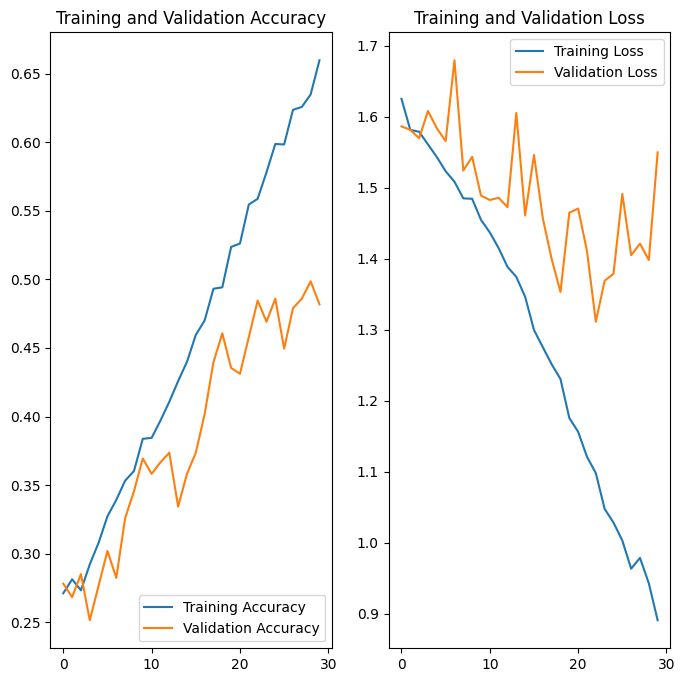

In [15]:
# plot the training results
plot_results(history)